In [3]:
import numpy as np
import cv2
import os
from scipy.spatial.distance import pdist,squareform

## Kernel Eigenfaces

In [39]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

def imread(path,H,W):
    '''
    :param path:
    :param H:
    :param W:
    :return:  (W*H, # pics) ndarray , (# pics) ndarray
    '''
    pics=os.listdir(path)
    images=np.zeros((W*H,len(pics)))
    labels=np.zeros(len(pics)).astype('uint8')
    for pic,i in zip(pics,np.arange(len(pics))):
        labels[i]=int(pic.split('.')[0][7:9])-1
        image=np.asarray(Image.open(os.path.join(path,pic)).resize((W,H),Image.ANTIALIAS)).flatten()
        images[:,i]=image

    return images,labels

def show_eigenface(X,num,H,W):
    '''
    :param X: (H*W, low-dim) ndarray
    :param num: # of showing faces
    :param H:
    :param W:
    :return: 
    '''
    n=int(num**0.5)
    for i in range(num):
        plt.subplot(n,n,i+1)
        plt.imshow(X[:,i].reshape(H,W),cmap='gray')
    #plt.get_current_fig_manager().window.showMaximized()
    plt.show()

def show_reconstruction(X,X_recover,num,H,W):
    '''
    :param X:  (H*W,# person picture=135) ndarray
    :param X_recover:  (H*W# person picture=135) ndarray
    :param num:  # of showing faces
    :param H:
    :param W:
    :return:
    '''
    randint=np.random.choice(X.shape[1],num)
    for i in range(num):
        plt.subplot(2,num,i+1)
        plt.imshow(X[:,randint[i]].reshape(H,W),cmap='gray')
        plt.subplot(2,num,i+1+num)
        plt.imshow(X_recover[:,randint[i]].reshape(H,W),cmap='gray')
    #plt.get_current_fig_manager().window.showMaximized()
    plt.show()

def performance(X_test,y_test,Z_train,y_train,U,X_mean=None,k=3):
    '''
    using k-nn to predict X_test's label
    :param X_test:  (H*W, # pics) ndarray
    :param y_test:   (# pics) ndarray
    :param Z_train:  (low-dim, #pics) ndarray
    :param y_train:  (# pics) ndarray
    :param U: Transform matrix
    :param X_mean:  using when estimate eigenface
    :param k: k of k-nn
    :return:
    '''
    if X_mean is None:
        X_mean=np.zeros((X_test.shape[0],1))

    # reduce dim (projection)
    Z_test=U.T@(X_test-X_mean)

    # k-nn
    predicted_y=np.zeros(Z_test.shape[1])
    for i in range(Z_test.shape[1]):
        distance=np.zeros(Z_train.shape[1])
        for j in range(Z_train.shape[1]):
            distance[j]=np.sum(np.square(Z_test[:,i]-Z_train[:,j]))
        sort_index=np.argsort(distance)
        nearest_neighbors=y_train[sort_index[:k]]
        unique, counts = np.unique(nearest_neighbors, return_counts=True)
        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), key=lambda item: -item[1])]
        predicted_y[i]=nearest_neighbors[0]

    acc=np.count_nonzero((y_test-predicted_y)==0)/len(y_test)
    return acc

In [70]:

def pca(X,num_dim=None):
    X_mean = np.mean(X, axis=1).reshape(-1, 1)
    X_center = X - X_mean

    # PCA
    eigenvalues, eigenvectors = np.linalg.eig(X_center.T @ X_center)
    sort_index = np.argsort(-eigenvalues)
    if num_dim is None:
        for eigenvalue, i in zip(eigenvalues[sort_index], np.arange(len(eigenvalues))):
            if eigenvalue <= 0:
                sort_index = sort_index[:i]
                break
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=eigenvalues[sort_index]
    # from X.T@X eigenvector to X@X.T eigenvector
    eigenvectors=X_center@eigenvectors[:, sort_index]
    eigenvectors_norm=np.linalg.norm(eigenvectors,axis=0)
    eigenvectors=eigenvectors/eigenvectors_norm

    return eigenvalues,eigenvectors,X_mean

In [64]:
def lda(X,y,num_dim=None):
    N=X.shape[0]
    X_mean = np.mean(X, axis=1).reshape(-1, 1)

    classes_mean = np.zeros((N, 15))  # 15 classes
    for i in range(X.shape[1]):
        classes_mean[:, y[i]] += X[:, y[i]]
    classes_mean = classes_mean / 9

    # within-class scatter
    S_within = np.zeros((N, N))
    for i in range(X.shape[1]):
        d = X[:, y[i]].reshape(-1,1) - classes_mean[:, y[i]].reshape(-1,1)
        S_within += d @ d.T

    # between-class scatter
    S_between = np.zeros((N, N))
    for i in range(15):
        d = classes_mean[:, i].reshape(-1,1) - X_mean
        S_between += 9 * d @ d.T

    eigenvalues,eigenvectors=np.linalg.eig(np.linalg.inv(S_within)@S_between)
    sort_index=np.argsort(-eigenvalues)
    if num_dim is None:
        sort_index=sort_index[:-1]  # reduce 1 dim
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')

    return eigenvalues,eigenvectors

sigmoid kernel
U shape: (45045, 85)


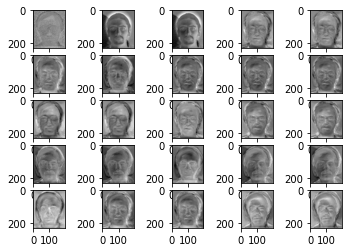

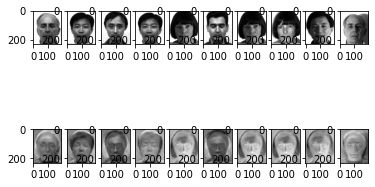

acc: 83.33%


/home/corrine1106/.conda/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part


In [71]:
#eigenface
filepath=os.path.join('Yale_Face_Database','Training')
H,W=231,195
X,y=imread(filepath,H,W)

eigenvalues,eigenvectors,X_mean=pca(X)
# Transform matrix
U=eigenvectors.copy()
print('U shape: {}'.format(U.shape))

# show top 25 eigenface
show_eigenface(U.real,25,H,W)

# reduce dim (projection)
Z=U.T@(X-X_mean)

# recover
X_recover=U@Z+X_mean
show_reconstruction(X.real,X_recover.real,10,H,W)

# accuracy
filepath=os.path.join('Yale_Face_Database','Testing')
X_test,y_test=imread(filepath,H,W)
acc=performance(X_test,y_test,Z,y,U,X_mean,3)
print('acc: {:.2f}%'.format(acc*100))

In [66]:
X.shape

(45045, 135)

RBF kernel
U shape: (45045, 30)


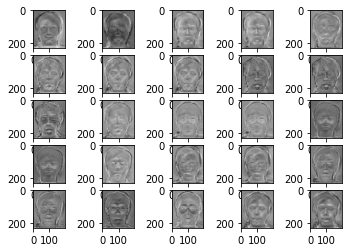

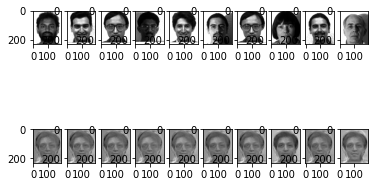

acc: 6.67%


In [67]:
#fisherface
filepath=os.path.join('Yale_Face_Database','Training')
H,W=231,195
X,y=imread(filepath,H,W)

eigenvalues_pca,eigenvectors_pca,X_mean=pca(X,num_dim=31)
X_pca=eigenvectors_pca.T@(X-X_mean)
eigenvalues_lda,eigenvectors_lda=lda(X_pca.real,y)

# Transform matrix
U=eigenvectors_pca@eigenvectors_lda
print('U shape: {}'.format(U.shape))

# show top 25 eigenface
show_eigenface(U.real,25,H,W)

# reduce dim (projection)
Z=U.T@X

# recover
X_recover=U@Z+X_mean
show_reconstruction(X.real,X_recover.real,10,H,W)

# accuracy
filepath = os.path.join('Yale_Face_Database', 'Testing')
X_test, y_test = imread(filepath, H, W)
acc = performance(X_test, y_test, Z, y, U, X_mean, 20)
print('acc: {:.2f}%'.format(acc * 100))

## t-SNE

In [78]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 600
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)
    #array_Y = []
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
        
        if iter % 10 == 0:
            #array_Y.append(Y)
            #pylab.clf()
            #pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
            
            #pylab.savefig(os.path.join('tSNE iter','iter{}.png'.format(iter)))
        
    #plot_similarity(P,Q)

    return Y

def plot_similarity(P,Q):
    pylab.subplot(2,1,1)
    pylab.title('tSNE high-dim')
    pylab.hist(P.flatten(),bins=40,log=True)
    pylab.subplot(2,1,2)
    pylab.title('tSNE low-dim')
    pylab.hist(Q.flatten(),bins=40,log=True)
    pylab.show()




print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
print("Running example on 2,500 MNIST digits...")
X = np.loadtxt("tsne_python/mnist2500_X.txt")
labels = np.loadtxt("tsne_python/mnist2500_labels.txt")
Y = tsne(X, 2, 50, 20.0)
#pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#pylab.show()



Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.467475
Iteration 20: error is 20.799172
Iteration 30: error is 17.944475
Iteration 40: error is 16.827582
Iteration 50: error is 16.481095
Iteration 60: error is 16.327988
Iteration 70: error is 16.197306
Iteration 80: error is 16.097833
Iteration 90: error is 16.022116
Iteration 100: error is 15.973016
Iteration 110: error is 2.326175
Iteration 120: error is 2.096468
Iteration 130: error is 1.912136
Iteration 140: error is 1.771941
Iteration 150: error is 1.663719
Iteration 160: error is 1.578709
Iteration 170: error is 1.510464
It

In [110]:
colormap= np.random.choice(range(256),size=(100,3))
from array2gif import write_gif
plot_Y = []
for cluster in Y:
    res=np.zeros((200,250,3))
    for number,point in enumerate(cluster):
        #print(int(point[1])+100)
        res[int(point[0])+100,int(point[1])+125,:]=colormap[int(labels[number]),:]
    plot_Y.append(res)
write_gif(plot_Y, 't-SNE.gif')

Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.822817
Iteration 10: error is 20.295889
Iteration 20: error is 16.650883
Iteration 30: error is 15.303215
Iteration 40: error is 15.444615
Iteration 50: error is 15.393657
Iteration 60: error is 15.400790
Iteration 70: error is 15.406919
Iteration 80: error is 15.395744
Iteration 90: error is 15.399519
Iteration 100: error is 15.397121
Iteration 110: error is 1.872306
Iteration 120: error is 1.797844
Iteration 130: error is 1.803275
Iteration 140: error is 1.814849
Iteration 150: error is 1.811987
Iteration 160: error is 1.808576
Iteration 170: error is 1.808158
Iteration 180: error is 1.808290
Iteration 190: error is 1.806953
Iteration 20

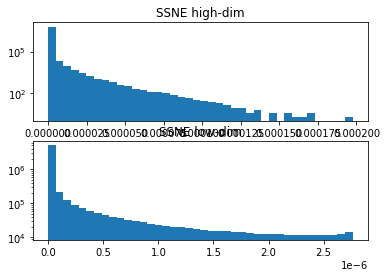

In [122]:
#symmetricSNE
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

def symmetric_sne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs symmetric SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 501
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)
    #array_Y = []
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num=np.exp(-(num+sum_Y+sum_Y.reshape(-1,1)))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.dot(PQ[i,:],Y[i,:]-Y)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
        
        # save scatter plot
        '''if iter % 10 == 0:
            
            pylab.clf()
            pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
            pylab.savefig(os.path.join('SSNE iter','iter{}.png'.format(iter)))'''
    plot_similarity(P,Q)

    # Return solution
    return Y

def plot_similarity(P,Q):
    pylab.subplot(2,1,1)
    pylab.title('SSNE high-dim')
    pylab.hist(P.flatten(),bins=40,log=True)
    pylab.subplot(2,1,2)
    pylab.title('SSNE low-dim')
    pylab.hist(Q.flatten(),bins=40,log=True)
    pylab.show()


print("Running example on 2,500 MNIST digits...")
X = np.loadtxt("tsne_python/mnist2500_X.txt")
labels = np.loadtxt("tsne_python/mnist2500_labels.txt")
Y = symmetric_sne(X, 2, 50, 50.0)
#pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#pylab.show()

In [114]:
Y

array([[-0.78073976,  0.6607068 ],
       [-1.74968413,  3.37319827],
       [-3.32582715, -0.60832811],
       ...,
       [ 3.25400297, -2.04218425],
       [-0.26380252,  2.96579286],
       [ 1.51751085,  1.7054278 ]])

In [119]:
plot_Y = []
for cluster in Y:
    res=np.zeros((10,10,3))
    for number,point in enumerate(cluster):
        #print(int(point[1])+100)
        res[int(point[0])+5,int(point[1])+5,:]=colormap[int(labels[number]),:]
    plot_Y.append(res)
write_gif(plot_Y, 'symmetricSNE.gif')